In [1]:
from utils.utils import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## Epidemics

### GKAN

In [2]:
model_path = './saved_models_optuna/model-epidemics-gkan/epidemics-ic3-last/1/gkan'

In [8]:
pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

symb_model_black_box = fit_black_box_from_kan(
    model_path=model_path,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    theta=-np.inf,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [9]:
symb_model_black_box

\sum_{j}( x_j*(0.50012505 - 0.5002359*x_i)) - 0.500021000882037*x_i

In [10]:
pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

symb_model_spline_wise = fit_model(
    n_h_hidden_layers=2,
    n_g_hidden_layers=2,
    model_path=model_path,
    theta=0.1,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

Pruning node (0,0)


/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib

In [11]:
symb_model_spline_wise

\sum_{j}( -0.0269925850493294*x_j + (-tanh(x_i)**3 + 0.54257786*tanh(x_j - 0.18107511) + 0.19963905)**2 - 0.22901842*sin(x_i - 1.8392199) - 0.192606347909981) - log(log(0.116798653962998*(x_i + 0.980982437994127)**3 + 1) + 1) - 0.18769063 - 0.111655645/(-0.096539944*log(x_i) - 0.5858811)

### MLP-based baseline

In [ ]:
model_path_mpnn = './saved_models_optuna/model-epidemics-mpnn/epidemics-new-data/1'

In [ ]:
pysr_model = lambda : get_pysr_model(
    model_selection="score",
    random_state = 0,
    deterministic=True,
    parallelism='serial',
    n_iterations=150
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)


/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [ ]:
mpnn_symb

\sum_{j}( x_i*(0.49942818 - 0.49865368*x_j)) - 0.5019439*x_i

## Kuramoto

### GKAN

In [2]:
model_path = 'saved_models_optuna/model-kuramoto-gkan/kuramoto-ic3-last/1/gkan'

In [8]:
pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

symb_model_black_box = fit_black_box_from_kan(
    model_path=model_path,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    theta=0.001,
    pysr_model=pysr_model,
    sample_size=8000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [9]:
symb_model_black_box

\sum_{j}( -0.4993206*sin(x_i - x_j)) - 7.2677517e-6*exp(x_i) + 2.0025613

In [3]:
pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

symb_model_spline_wise = fit_model(
    n_h_hidden_layers=2,
    n_g_hidden_layers=2,
    model_path=model_path,
    theta=0.01,
    pysr_model=pysr_model,
    sample_size=8000,
    message_passing=False
)

Pruning node (0,1)


/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Pruning node (0,0)
Pruning node (0,1)


In [4]:
symb_model_spline_wise

\sum_{j}( 0.3271088*sin(1.2357323*x_i - 1.3089586*x_j + 3.2265232))

## Test Experiments

In [2]:
import optuna
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
from experiments.experiments_gkan import ExperimentsGKAN
from experiments.experiments_mpnn import ExperimentsMPNN

storage = JournalStorage(JournalFileBackend("optuna_journal_storage.log"))

### Kuramoto

In [4]:
optuna.delete_study(study_name="model-kuramoto-gkan-test-new-dataset", storage=storage)

In [4]:
config_path = './configs/config_kuramoto.yml'
config = load_config(config_path)
config['epochs'] = 10


exp = ExperimentsGKAN(
    config=config,
    n_trials=1,
    study_name='test-new-dataset',
    process_id=0,
    store_to_sqlite = False
)



In [5]:
exp.run()

[I 2025-04-16 22:20:54,803] A new study created in Journal with name: model-kuramoto-gkan-test-new-dataset
[I 2025-04-16 22:21:35,284] Trial 0 finished with value: 0.0011665469501167536 and parameters: {'lr': 0.013373430890941078, 'lamb': 1.0, 'batch_size': 32, 'use_orig_reg': False, 'lamb_g_net': 5.096932468900401e-05, 'lamb_h_net': 0.00016521859134792, 'grid_size_g_net': 5, 'spline_order_g_net': 2, 'range_limit_g_net': 10, 'mu_1_g_net': 0.8, 'mu_2_g_net': 0.9, 'hidden_dim_g_net': 2, 'grid_size_h_net': 9, 'spline_order_h_net': 2, 'range_limit_h_net': 10, 'mu_1_h_net': 1.0, 'mu_2_h_net': 0.6, 'hidden_dim_h_net': 2}. Best is trial 0 with value: 0.0011665469501167536.


### Test traffic data

In [3]:
from train_and_eval import fit, eval_model

In [4]:
optuna.delete_study(study_name="model-metrla-mpnn-test-new-dataset", storage=storage)

In [6]:
config_path = './configs/config_metrla_mpnn.yml'
config = load_config(config_path)
# config['epochs'] = 10
config['name'] = 'metrla2'
# config['stride'] = 1
config['n_iter'] = 2
# config['method'] = 'dopri5'
# config['num_samples'] = 96
# config['include_time'] = True
# config['message_passing'] = True
# config['adjoint'] = True
# config['horizon'] = 36
# config['atol'] = 0.00001
# config['rtol'] = 0.001
# config['device'] = 'cpu'

In [7]:
exp = ExperimentsMPNN(
    config=config,
    n_trials=1,
    study_name='test-new-dataset',
    process_id=0,
    store_to_sqlite = False,
    save_cache_data = False
)

Processing...


Building the dataset...


Done!


In [ ]:
exp.epochs = 5
exp.run()

## Data visualization METR-LA

In [6]:
import json
import matplotlib.pyplot as plt
from models.utils.MPNN import MPNN
from models.kan.KAN import KAN
from models.GKAN_ODE import GKAN_ODE
from models.utils.ODEBlock import ODEBlock
import torch
from models.utils.MLP import MLP
from models.baseline.MPNN_ODE import MPNN_ODE
from experiments.experiments_mpnn import activations


In [7]:
training_set, valid_set, test_set = exp.training_set, exp.valid_set, exp.test_set

In [8]:
len(training_set)

1142

In [21]:
scaler = exp.pre_processing(training_set)

In [41]:
from models.baseline.baseline import LB_ODE

LB_base = LB_ODE(model_path='./saved_models_optuna/tmp-lb')

eval_model(
    model=LB_base,
    valid_data=test_set,
    criterion=exp.criterion,
    scaler=scaler
)

4.179730415344238

In [12]:
eval_model(
    model=LB_base,
    valid_data=valid_set,
    criterion=exp.criterion,
    scaler=scaler,
    inverse_scale=False
)

0.1261630654335022

### Utils

In [9]:
def plot_results(train_losses, val_losses, train_label='Training Loss', val_label='Validation Loss', title='Loss over Epochs'):
    epochs = range(len(train_losses))
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label=train_label, marker='o')
    plt.plot(epochs, val_losses, label=val_label, marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [12]:
from torch_geometric.data import Data

def get_predictions(model:ODEBlock, data, time, scaler, edge_index, edge_attr):
    model.eval()
    input_length = 12
    total_seq_len = 2*input_length
    y_pred = []
    y_true = []
    with torch.no_grad():
        for ts in range(0, data.size(0) - total_seq_len + 1, input_length):
            idx_input = slice(ts, ts + input_length)
            idx_target = slice(ts + input_length, ts + total_seq_len)
            
            x = data[idx_input, :, :]
            y = data[idx_target, :, :]
            t_span = time[ts + input_length-1: ts + total_seq_len]
            x_mask = torch.ones_like(x, dtype=torch.bool)
            y_mask = torch.ones_like(y, dtype=torch.bool)
            
            in_ = Data(
                edge_index=edge_index,
                edge_attr=edge_attr,
                x=x if scaler is None else scaler.transform(x),  
                y=y if scaler is None else scaler.transform(y),
                t_span=t_span,
                x_mask = x_mask,
                mask=y_mask
            )
            
            y_hat = model(in_).view(y.size(0), y.size(1), y.size(2))
            y_pred.append(y_hat if scaler is None else scaler.inverse_transform(y_hat))
            y_true.append(y)
    
    y_pred = torch.stack(y_pred, dim=0)
    y_true = torch.stack(y_true, dim=0)
    
    return y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy() 
        
        
        

def plot_predictions(y_true, y_pred, node_index = 0):
    y_true = np.reshape(y_true, (-1, y_true.shape[2], y_true.shape[3]))
    y_pred = np.reshape(y_pred, (-1, y_pred.shape[2], y_pred.shape[3]))
    plt.figure(figsize=(16, 8))
    plt.plot(y_true[:, node_index, :], label='y_true', marker='o')
    plt.plot(y_pred[:, node_index, :], label='y_pred', marker='o')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.title(f'y_true vs y_pred for Node {node_index}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    

In [13]:
def build_model_from_file(best_params_file, best_state_path, message_passing, include_time, method='midpoint', adjoint=False):
    with open(best_params_file, 'r') as f:
        best_hyperparams = json.load(f)
    
    in_dim = 1
    augmented_input_dim = 11 * in_dim + 2*in_dim
    
    hidden_layers = [best_hyperparams["hidden_dims_g_net"] for _ in range(best_hyperparams["n_hidden_layers_g_net"])]
    hidden_layers = [in_dim + augmented_input_dim] + hidden_layers + [in_dim]    
    # g_net
    g_net = MLP(
        hidden_layers=hidden_layers,
        af = activations[best_hyperparams['af_g_net']],
        dropout_rate=best_hyperparams['drop_p_g_net'],
    )
    
    time_dim = 1 if include_time else 0
    in_dim_h = 2 if message_passing else 1
    in_dim_h += time_dim
    hidden_layers = [best_hyperparams["hidden_dims_h_net"] for _ in range(best_hyperparams["n_hidden_layers_h_net"])]
    hidden_layers = [in_dim_h + augmented_input_dim] + hidden_layers + [in_dim] 
    
    
    # h_net
    h_net = MLP(
        hidden_layers=hidden_layers,
        af = activations[best_hyperparams['af_h_net']],
        dropout_rate=best_hyperparams['drop_p_h_net'],
    )
    
    mpnn = MPNN(
        h_net=h_net,
        g_net=g_net,
        message_passing=message_passing,
        include_time=include_time
    )
    
    model = MPNN_ODE(
        conv=mpnn,
        model_path='./saved_models_optuna/tmp',
        integration_method=method,
        adjoint=adjoint
    )
    
    model = model.to(torch.device('cuda'))
    model.load_state_dict(torch.load(best_state_path, weights_only=False))
    
    return model

### GKAN-ODE

In [14]:
model_path_metrla = './saved_models_optuna/model-metrla-mpnn/metrla-augmented/0/mpnn'

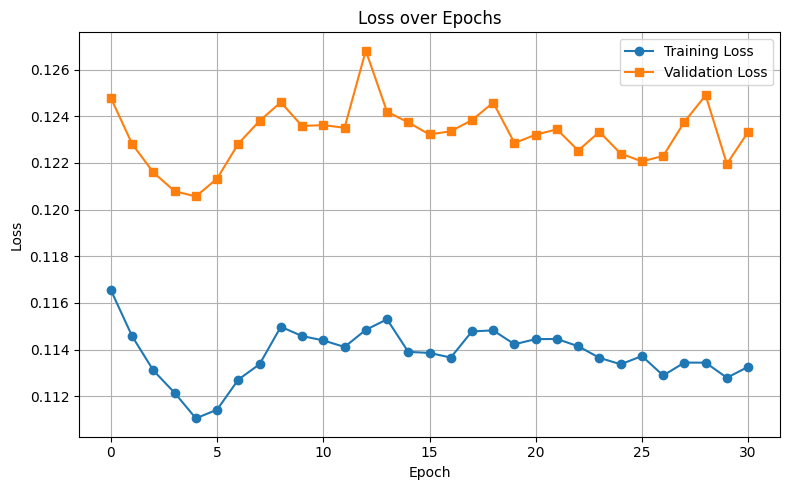

In [15]:
with open(f'{model_path_metrla}/results.json', 'r') as f:
    results = json.load(f)

plot_results(
    train_losses=results['train_loss'],
    val_losses=results['validation_loss'],
    train_label='Training Loss',
    val_label='Validation Loss',
    title='Loss over Epochs'
)

In [17]:
best_model = build_model_from_file(
    best_params_file='./saved_models_optuna/model-metrla-mpnn/metrla-augmented/0/best_params.json',
    best_state_path='./saved_models_optuna/model-metrla-mpnn/metrla-augmented/0/mpnn/state_dict.pth',
    message_passing=True,
    include_time=True,
    method='dopri5',
    adjoint=True
)

In [18]:
raw_data, raw_time = training_set.raw_data_sampled, training_set.t_sampled

In [19]:
best_model = best_model.to(torch.device('cuda'))

In [46]:
y_true, y_pred = get_predictions(
    model=best_model,
    data=raw_data[0][:288],   # first day
    time=raw_time[0][:288],   # first day
    scaler=scaler,
    edge_index=training_set[0].edge_index,
    edge_attr=training_set[0].edge_attr
)

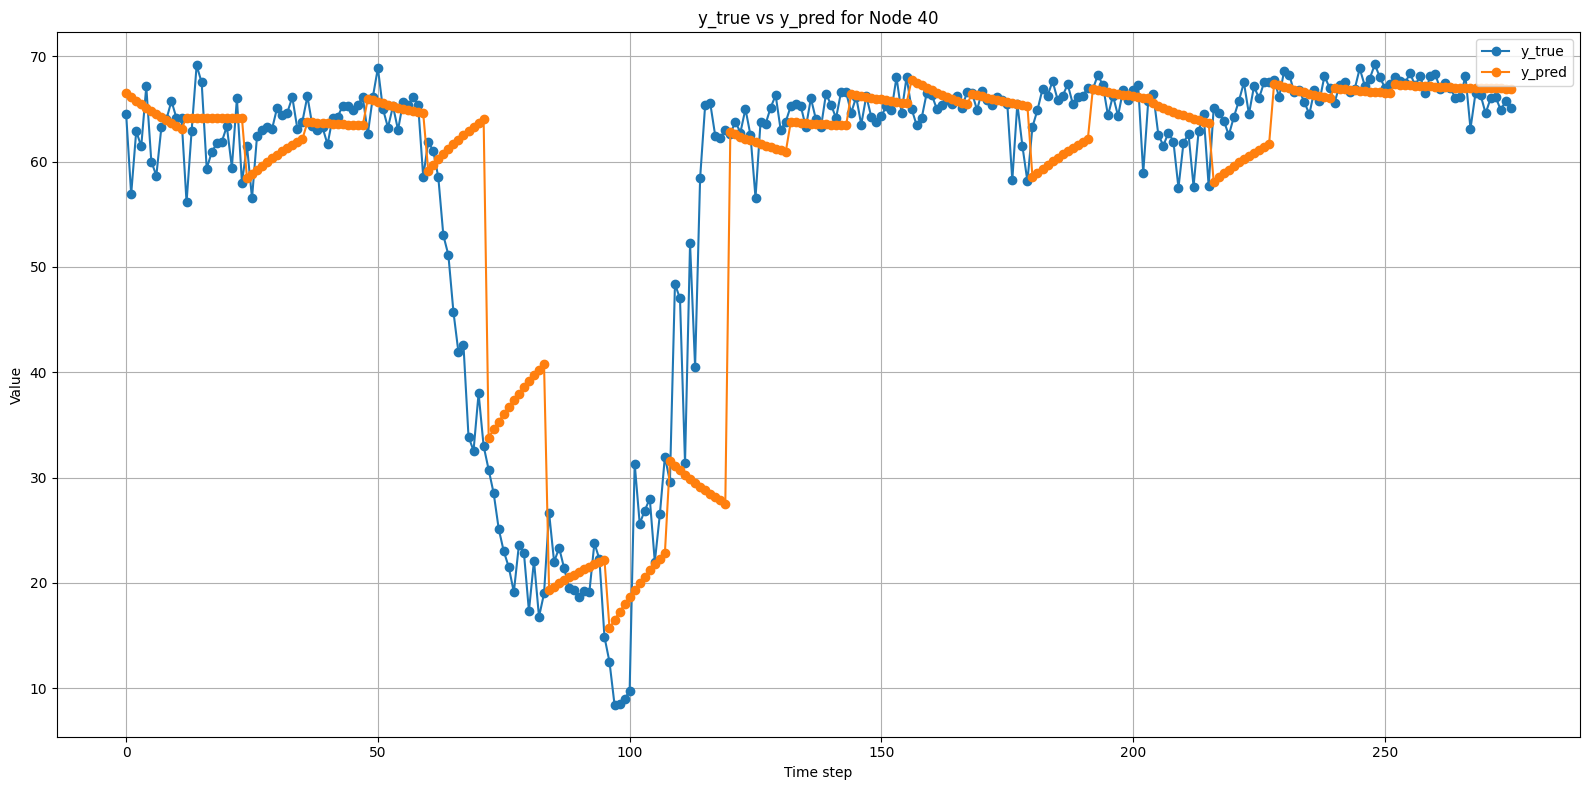

In [47]:
node_index = 40
plot_predictions(y_true=y_true, y_pred=y_pred, node_index=node_index)

### LB-Baseline

In [42]:
y_true, y_pred = get_predictions(
    model=LB_base,
    data=raw_data[0][:288],   # first day
    time=raw_time[0][:288],   # first day
    scaler=scaler,
    edge_index=training_set[0].edge_index,
    edge_attr=training_set[0].edge_attr
)

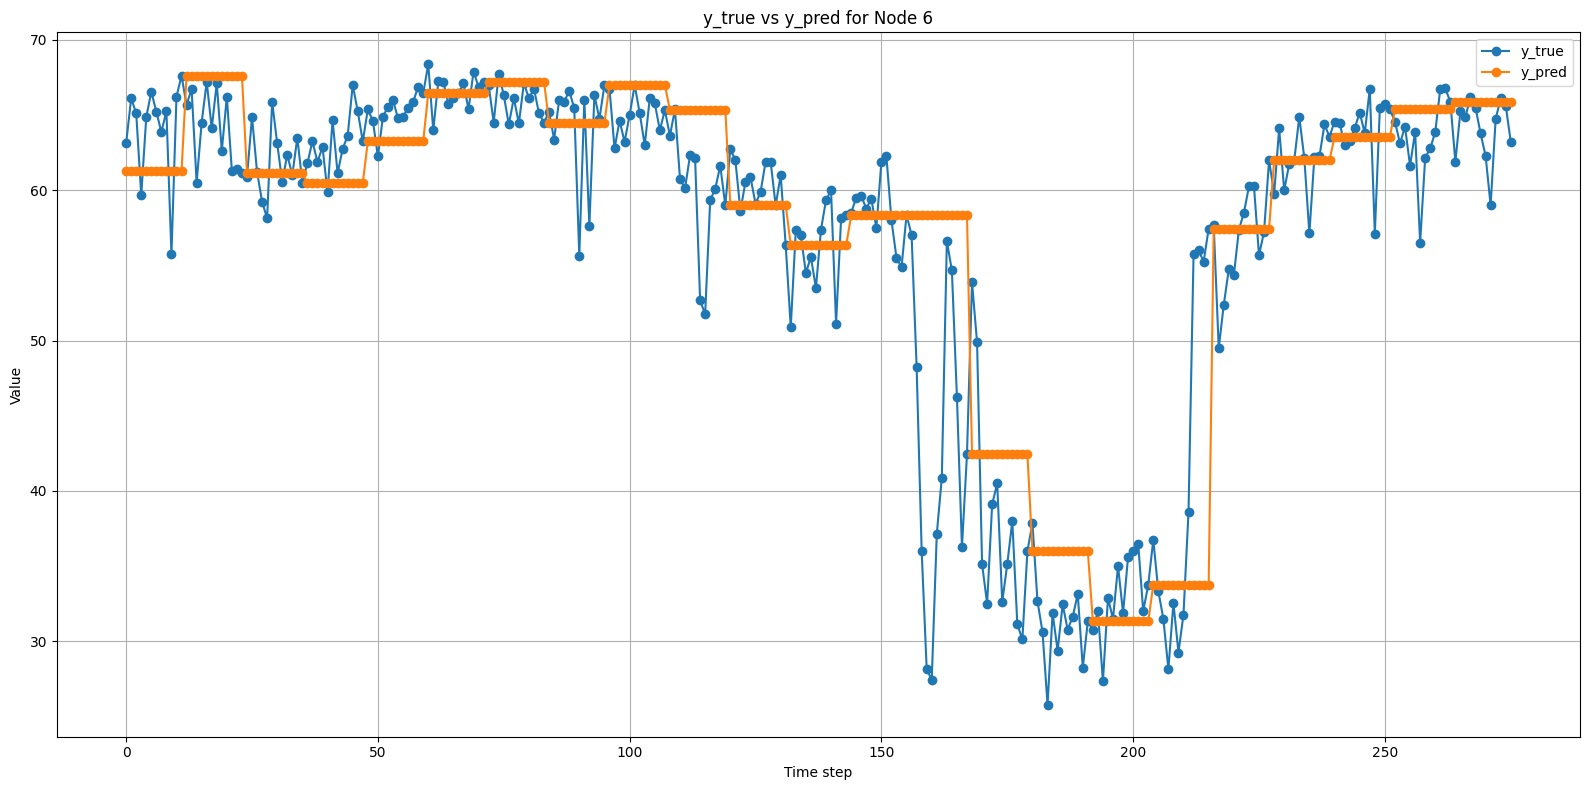

In [44]:
node_index = 6
plot_predictions(y_true=y_true, y_pred=y_pred, node_index=node_index)